# Uniaxial Tension - Elasticity, Physics Informed Neural Network

Thomas Allard and Samantha Walker

In [1]:
#Imports
import numpy as np 
import sciann as sn 
import matplotlib.pyplot as plt
import scipy.io
import netCDF4
import xarray as xr

import os

2022-04-21 20:38:03.974123: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/mnt/c/Windows/System32/xdmf/build/lib:/mnt/c/Windows/System32/yaml-cpp/build
2022-04-21 20:38:03.974216: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


---------------------- SCIANN 0.6.6.1 ---------------------- 
For details, check out our review paper and the documentation at: 
 +  "https://www.sciencedirect.com/science/article/pii/S0045782520307374", 
 +  "https://arxiv.org/abs/2005.08803", 
 +  "https://www.sciann.com". 

 Need support or would like to contribute, please join sciann`s slack group: 
 +  "https://join.slack.com/t/sciann/shared_invite/zt-ne1f5jlx-k_dY8RGo3ZreDXwz0f~CeA" 
 
TensorFlow Version: 2.5.3 
Python Version: 3.8.12 | packaged by conda-forge | (default, Jan 30 2022, 23:53:36) 
[GCC 9.4.0] 



In [2]:
# Specify parameters and things
mode = 'train'   # 'test' to load PINN weights from previously trained model
                # 'train' to train a new model

#trained_file = 'trained-navier-stokes.hdf5'
data_file = '../abaqus/final_elastic/elastic_cdf.nc'

In [3]:
# load in data_file as xarray DataSet
set = xr.open_dataset(data_file)

In [4]:
# Load in displacements and create an ndarray
disp_x=set.sel(field='ux').to_array()
disp_y=set.sel(field='uy').to_array()
disps=np.dstack([disp_x,disp_y])
print(np.shape(disps))
# Num = np.shape(disps)[1] # 2760
# Var_Num = np.shape(disps)[2] # 2

(81, 2760, 2)


In [5]:
# Load in grid
def file2array(file):
    # load in each line of data as array
    with open(file, 'r') as f:
        line_string = f.read().splitlines()
    
    # loop through the lines from the file, split, and append to list
    list = []
    timestamp = 0 # default 
    for i, line in enumerate(line_string):
        list.append(line.split())

    # convert list to an array of type float64
    array = np.asarray(list, dtype=np.float64)

    return(array)
node_file = '../abaqus/final_elastic/nodes.txt'
nodal_coordinates = file2array(node_file)
grid = nodal_coordinates[:,1:3]
print(grid)
print(np.shape(grid))

[[    0.        -1500.       ]
 [   66.6666641 -1500.       ]
 [  133.333328  -1500.       ]
 ...
 [ 2866.66675    1500.       ]
 [ 2933.33325    1500.       ]
 [ 3000.         1500.       ]]
(2760, 2)


In [6]:
# Extract time and put in an array
time = [] # will be shape (81,)
for DataArray in set.values():
    time.append(DataArray.attrs['time'])

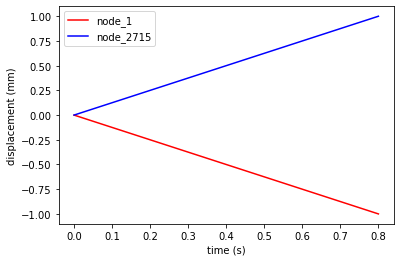

In [7]:
# Check that data loaded in correctly by plotting disp_y for node 1 (bottom left) and node 2715 (top left)
plt.plot(time,set.sel(field='uy',node='1').to_array(),   color='red',label='node_1')
plt.plot(time,set.sel(field='uy',node='2715').to_array(),color='blue',label='node_2715')
plt.xlabel('time (s)')
plt.ylabel('displacement (mm)')
plt.legend()
plt.show()

In [8]:
#disp_x=set.sel(field='ux').to_array()
print(np.shape(disp_x)) # (81, 2760)
P_star = set.sel(field='S22').to_array() #(81, 2760)
print(np.shape(P_star))
print(P_star)

(81, 2760)
(81, 2760)
<xarray.DataArray (variable: 81, node: 2760)>
array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [  1.92306888,   1.92306888,   1.92306888, ...,   1.92306888,
          1.92306888,   1.92306888],
       [  3.84612179,   3.84612179,   3.84612179, ...,   3.84612179,
          3.84612179,   3.84612179],
       ...,
       [149.95127869, 149.95127869, 149.95127869, ..., 149.95127869,
        149.95127869, 149.95127869],
       [151.87309265, 151.87309265, 151.87309265, ..., 151.87309265,
        151.87309265, 151.87309265],
       [153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136]])
Coordinates:
  * node      (node) object '1' '2' '3' '4' '5' ... '2757' '2758' '2759' '2760'
    field     <U3 'S22'
  * variable  (variable) <U8 'step_000' 'step_001' ... 'step_079' 'step_080'


In [9]:
np.shape(grid)

(2760, 2)

In [10]:
# define function for subsampling data
def PrepareData(data, grid, time, random=True): # num_data, data_file
    
    # Load data
    #data = scipy.io.loadmat('/content/' + data_file)
    #data = scipy.io.loadmat(data_file)
    
    # will want to change these to correspond to our input variables
    #U_star = data['U_star'] # N x 2 x T
    ## displacements -> U_star
    disp_x=set.sel(field='ux').to_array() # T x N # (81, 2760)
    disp_y=set.sel(field='uy').to_array() # T x N # (81, 2760)
    U_star=np.dstack([disp_x,disp_y])     # T x N x 2 (81, 2760, 2)
    
    # time
    time = [] # will be shape (81,)
    for DataArray in set.values():
        time.append(DataArray.attrs['time'])
    
    # Solution S22 -> P_star
    P_star = np.asarray(set.sel(field='S22').to_array()) # T x N
    print(np.shape(P_star))
    
    # time -> t_star
    t_star = time #data['t'] # T x 1 # (81,)
    
    # grid -> X_star
    X_star = grid # grid is N x 2 or shape (2760, 2)
    
    N = np.shape(X_star)[0] #X_star.shape[0]
    T = np.shape(t_star)[0] #t_star.shape[0]
    
    # Rearrange Data 
    XX = np.tile(X_star[:,0:1], (1,T)) # N x T # (2760, 81)
    YY = np.tile(X_star[:,1:2], (1,T)) # N x T # (2760, 81)
    TT = np.tile(t_star, (1,N)).T # NT x 1 # (223560, 1)
    
    UU = U_star[:,:,0].T # N x T
    VV = U_star[:,:,1].T # N x T
    PP = P_star.T # N x T
    print(np.shape(PP)) # N x T
    
    # Pick random data.
    if random:
        idx = np.random.choice(N*T, N, replace=False) # num_data
    else:
        idx = np.arange(0, N*T)
    
    x = XX
    y = YY
    t = t_star
    
    x = XX.flatten()[idx,None] # NT x 1
    y = YY.flatten()[idx,None] # NT x 1
    t = TT.flatten()[idx,None] # NT x 1
    
    u = UU # T x N # (81, 2760)
    v = VV # T x N # (81, 2760)
    p = PP # T x N # (81, 2760)
    
    u = UU.flatten()[idx,None] # NT x 1
    v = VV.flatten()[idx,None] # NT x 1
    p = PP.flatten()[idx,None] # NT x 1
 
    return (x,y,t,u,v,p)


In [11]:
x,y,t,u,v,p = PrepareData(set, grid, time, random=True)
# print(data_prep)
#print(disp_x.shape) # [:,2759]
#print(t.shape) # [:,80]
print(np.shape(x))
print(np.shape(y))
print(np.shape(t))
print(np.shape(u))
print(np.shape(v))
print(np.shape(p))

(81, 2760)
(2760, 81)
(2760, 1)
(2760, 1)
(2760, 1)
(2760, 1)
(2760, 1)
(2760, 1)


(81, 2760)
(2760, 81)
../logs/log_layers8_neurons20_epochs100_batchsize100_learning_rate0.001_reduce_lr_after1000 is created!

Total samples: 2760 
Batch size: 100 
Total batches: 28 



2022-04-21 20:53:28.643996: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/mnt/c/Windows/System32/xdmf/build/lib:/mnt/c/Windows/System32/yaml-cpp/build
2022-04-21 20:53:28.644865: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-21 20:53:28.644979: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (DESKTOP-KVJB0RN): /proc/driver/nvidia/version does not exist
2022-04-21 20:53:28.647247: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-21

Epoch 1/100
28/28 [==============================] - 33s 72ms/step - batch: 13.5000 - size: 98.5714 - loss: 7649.8561 - Grad__43_loss: 0.0797 - mul_19_loss: 0.1169 - P_loss: 7649.9343 - sub_11_loss: 1.6224e-04 - sub_13_loss: 1.6956e-04 - add_20_loss: 3.4425e-04 - mul_26_loss: 0.0000e+00 - lr: 0.0010 - time: 31.8216 - mu: 0.2797 - lambda: 0.4942
Epoch 2/100
28/28 [==============================] - 0s 12ms/step - batch: 13.5000 - size: 98.5714 - loss: 7223.3358 - Grad__43_loss: 0.0802 - mul_19_loss: 0.1174 - P_loss: 7223.7973 - sub_11_loss: 2.8806e-04 - sub_13_loss: 2.9090e-04 - add_20_loss: 4.8701e-05 - mul_26_loss: 0.0000e+00 - lr: 0.0010 - time: 0.3406 - mu: 0.2826 - lambda: 0.4912
Epoch 3/100
28/28 [==============================] - 0s 13ms/step - batch: 13.5000 - size: 98.5714 - loss: 6909.2375 - Grad__43_loss: 0.0799 - mul_19_loss: 0.1168 - P_loss: 6909.1332 - sub_11_loss: 0.0028 - sub_13_loss: 0.0028 - add_20_loss: 3.6460e-05 - mul_26_loss: 0.0000e+00 - lr: 0.0010 - time: 0.4597 -

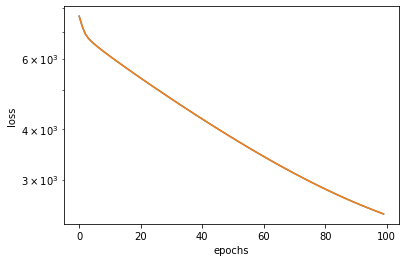

In [16]:
# Setting up cost function
layers = 8
neurons = 20

x = sn.Variable("x", dtype='float64')
y = sn.Variable("y", dtype='float64')
t = sn.Variable("t", dtype='float64')

P = sn.Functional("P", [x, y, t], layers*[neurons], 'tanh') # HMMMMM?
Psi = sn.Functional("Psi", [x, y, t], layers*[neurons], 'tanh') # HMMMMM?

'''
Abaqus takes E and nu
The Navier form of equations takes mu and lambda

E = [mu*(3*lambda + 2*mu)] / [lambda + mu]
nu = lambda / [2*(lambda + mu)]

mu = E / [2*(1 + nu)]
lambda = [nu*E] / [(1 + nu)*(1 - 2*nu)]

Inputs values:
E  = 210 GPa
nu = 0.3

Expected values:
mu     =  63.636363 GPa
lambda = 121.154385 GPa
'''

mu = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="mu")
lamb = sn.Parameter(np.random.rand(), inputs=[x,y,t], name="lambda")

# lets hope this functional works lol, define u and v
u = sn.diff(Psi, y)
v = -sn.diff(Psi, x)

# partials
u_t = sn.diff(u, t)
u_x = sn.diff(u, x)
u_y = sn.diff(u, y)
u_tt = sn.diff(u, t, order=2)
u_xx = sn.diff(u, x, order=2)
u_yy = sn.diff(u, y, order=2)
u_xy = sn.diff(u_x, y)

v_t = sn.diff(v, t)
v_x = sn.diff(v, x)
v_y = sn.diff(v, y)
v_tt = sn.diff(v, t, order=2)
v_xx = sn.diff(v, x, order=2)
v_yy = sn.diff(v, y, order=2)
v_xy = sn.diff(v_x, y)

p_x = sn.diff(P, x)   # recyled, shouldn't be this way lol
p_y = sn.diff(P, y)   # recyled, shouldn't be this way lol

# define constraints
d1 = sn.Data(u)
d2 = sn.Data(v)
d3 = sn.Data(P) # HMMMMM?

#rho = 1.0
c1 = sn.Tie(p_x,mu*u_xx + (lamb+mu)*u_xy - u_tt) # f, no way this should work with p_x lol
c2 = sn.Tie(p_x,mu*v_yy + (lamb+mu)*v_xy - v_tt) # g, no way this should work with p_y lol
c3 = sn.Data(u_yy -((lamb/mu)+1)*u_xy - v_xx + ((lamb/mu)+1)*v_xy) #symmetry constraint

c4 = Psi*0.0 # lol lets keep it

if mode == 'train':
    x_train, y_train, t_train, u_train, v_train, p_train = PrepareData(set, grid, time, random=True)
    
    model = sn.SciModel(
        inputs=[x, y, t],
        targets = [d1, d2, d3, c1, c2, c3, c4],
        loss_func = "mse",
        plot_to_file = "NS-Model.png"
    )
    
    input_data = [x_train, y_train, t_train]

    # like an initial condition for c1, c2, c3, and c4
    data_d1 = u_train
    data_d2 = v_train
    data_d3 = p_train
    data_c1 = 'zeros'
    data_c2 = 'zeros'
    data_c3 = 'zeros'
    data_c4 = 'zeros'
    target_data = [data_d1, data_d2, data_d3, data_c1, data_c2, data_c3, data_c4]

    ## hyper parameter define

    Epochs= 100
    Batch_size=100
    Learning_rate=0.001
    Reduce_lr_after=1000
    
#log the data

    log_directory = f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}'

    if not os.path.exists(log_directory):
        os.makedirs(log_directory)
        print(f'{log_directory} is created!')

    ##train PINN

    history = model.train(
        x_true=input_data,
        y_true=target_data,
        epochs= Epochs,
        batch_size= Batch_size,
        shuffle=True,
        learning_rate= Learning_rate,
        reduce_lr_after= Reduce_lr_after,
        stop_loss_value=1e-8,
        verbose=1,
        log_parameters={'parameters':[mu,lamb],
                        'freq':1}
    )
    
    ## logs and plots
    model.save_weights('elasticity_train.hdf5')
    ## print iterated parameters value
    print("mu: {},  lamb: {}".format(mu.value, lamb.value))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/parameters_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"mu: {mu.value},  lamb: {lamb.value}")
    print("mu: {},  lamb: {}".format(mu.value, lamb.value))
    
    ## print loss function value
    print("loss: {}".format(history.history['loss']))
    with open(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.txt', 'w') as f:
        f.write(f"loss: {history.history['loss']}")
    ## plot loss function
    plt.figure(f'Train_Loss_{layers}_{neurons}')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')
    plt.savefig(f'../logs/log_layers{layers}_neurons{neurons}_epochs{Epochs}_batchsize{Batch_size}_learning_rate{Learning_rate}_reduce_lr_after{Reduce_lr_after}/loss_{layers}_{neurons}.png')
    plt.semilogy(history.history['loss'])
    plt.xlabel('epochs')
    plt.ylabel('loss')

In [19]:


np.shape(U_star)
U_star = np.moveaxis(U_star, 0, -1)
np.shape(U_star)

(2760, 2, 81)

In [30]:
#Arrange data for plotting

# Load data
#data = scipy.io.loadmat(data_file)
#p_pred = test_result[2]

# Unpacking the .nc file 

disp_x=set.sel(field='ux').to_array() # T x N # (81, 2760)
disp_y=set.sel(field='uy').to_array() # T x N # (81, 2760)
U_star=np.dstack([disp_x,disp_y])     # T x N x 2 (81, 2760, 2)
U_star = np.moveaxis(U_star, 0, -1)# N x 2 x T

P_star = np.asarray(set.sel(field='S22').to_array()).T # N x T
t_star = time #data['t'] # T x 1 
X_star = grid # grid is N x 2 or shape (2760, 2)
    
snap = np.array([80])
x_star = X_star[:,0:1]
y_star = X_star[:,1:2]
p_star = P_star[:,snap]
#p_test = P_pred[:,snap]
# Predict for plotting
lb = X_star.min(0)
ub = X_star.max(0)
nn = 200
x = np.linspace(lb[0], ub[0], nn)
y = np.linspace(lb[1], ub[1], nn)
X, Y = np.meshgrid(x,y)

from scipy.interpolate import griddata
P_exact = griddata(X_star, p_star.flatten(), (X, Y))

#PP_star = griddata(X_star, p_pred.flatten(), (X, Y), method='cubic')

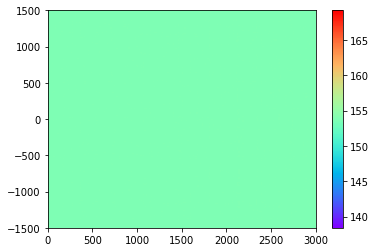

In [31]:
# Plot "exact" pressure field
#plt.imshow(P_exact, interpolation='nearest', cmap='rainbow', 
#                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
#                  origin='lower', aspect='auto')

plt.imshow(P_exact, cmap='rainbow', 
                  extent=[x_star.min(), x_star.max(), y_star.min(), y_star.max()], 
                  origin='lower', aspect='auto')
plt.colorbar()

In [29]:
P_exact

array([[153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136],
       [153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136],
       [153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136],
       ...,
       [153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136],
       [153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136],
       [153.79489136, 153.79489136, 153.79489136, ..., 153.79489136,
        153.79489136, 153.79489136]])